# Load Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

Using TensorFlow backend.


# Data Preparation

In [5]:
df = pd.read_csv('02-02-2018-TO-01-02-2019SBINEQN.csv', parse_dates=['Date'], index_col=['Date'])
print(df.shape)
df.head()

(247, 14)


,Symbol,Series,Prev Close,Open Price,High Price,Low Price,Last Price,Close Price,Average Price,Total Traded Quantity,Turnover,No. of Trades,Deliverable Qty,% Dly Qt to Traded Qty
Date,,,,,,,,,,,,,,
2018-02-02,SBIN,EQ,306.05,302.90,305.75,295.50,295.80,297.35,300.07,23274673,6.984012e+09,156709,7281514,31.29
2018-02-05,SBIN,EQ,297.35,292.65,300.40,290.00,299.00,298.05,295.64,18940578,5.599668e+09,134857,5090174,26.87
2018-02-06,SBIN,EQ,298.05,285.00,297.30,282.90,294.60,291.75,289.73,30577218,8.859223e+09,241764,14119757,46.18
2018-02-07,SBIN,EQ,291.75,296.60,297.90,290.00,292.10,292.80,293.38,21463818,6.297080e+09,161931,7255476,33.80
2018-02-08,SBIN,EQ,292.80,292.90,303.30,292.55,302.25,301.40,298.60,18932796,5.653383e+09,125388,5457942,28.83


In [6]:
master_df = df[['Close Price']]
master_df.head()

,Close Price
Date,
2018-02-02,297.35
2018-02-05,298.05
2018-02-06,291.75
2018-02-07,292.80
2018-02-08,301.40


In [7]:
train_df = master_df.loc[(master_df.index <= '2018-12-31')]
print(train_df.shape)
train_df.head()

(223, 1)


,Close Price
Date,
2018-02-02,297.35
2018-02-05,298.05
2018-02-06,291.75
2018-02-07,292.80
2018-02-08,301.40


In [8]:
test_df = master_df.loc[(master_df.index > '2018-12-31')]
print(test_df.shape)
test_df.head()

(24, 1)


,Close Price
Date,
2019-01-01,299.60
2019-01-02,293.90
2019-01-03,291.10
2019-01-04,297.65
2019-01-07,296.30


# EDA

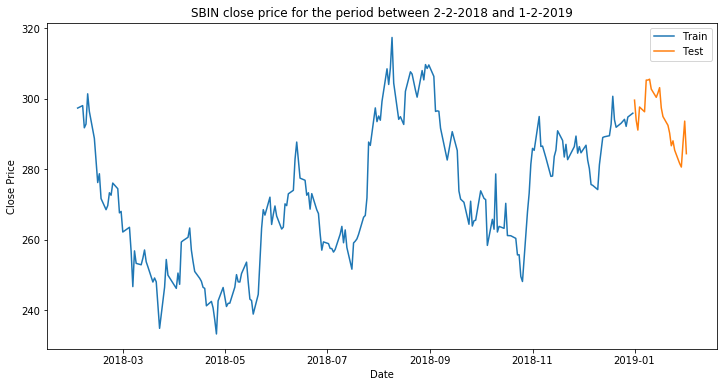

In [6]:
plt.figure(figsize=(12,6))
plt.plot(train_df.index, train_df['Close Price'], label='Train')
plt.plot(test_df.index, test_df['Close Price'], label='Test')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend(loc='best')
plt.title('SBIN close price for the period between 2-2-2018 and 1-2-2019')
plt.show()

# Estimating & Eliminating Trend

#### Log Transform
To reduce the trend, we can transform the data to log, square root, cube root, etc.

In [7]:
#train_log_df = np.log(train_df)
#test_log_df = np.log(test_df)

In [8]:
'''
# Log transformed
plt.figure(figsize=(12,6))
plt.plot(train_df.index, train_log_df, label='Train')
plt.plot(test_df.index, test_log_df, label='Test')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend(loc='best')
plt.title('SBIN close price for the period between 2-2-2018 and 1-2-2019')
plt.show()
'''

"\n# Log transformed\nplt.figure(figsize=(12,6))\nplt.plot(train_df.index, train_log_df, label='Train')\nplt.plot(test_df.index, test_log_df, label='Test')\nplt.xlabel('Date')\nplt.ylabel('Close Price')\nplt.legend(loc='best')\nplt.title('SBIN close price for the period between 2-2-2018 and 1-2-2019')\nplt.show()\n"

### Measuring Trends using Moving Average

In [9]:
moving_avg_df = train_df.rolling(6).mean()
moving_avg_df.head(20)

,Close Price
Date,
2018-02-02,NaN
2018-02-05,NaN
2018-02-06,NaN
2018-02-07,NaN
2018-02-08,NaN
2018-02-09,296.291667
2018-02-12,294.858333
2018-02-14,291.216667
2018-02-15,289.041667


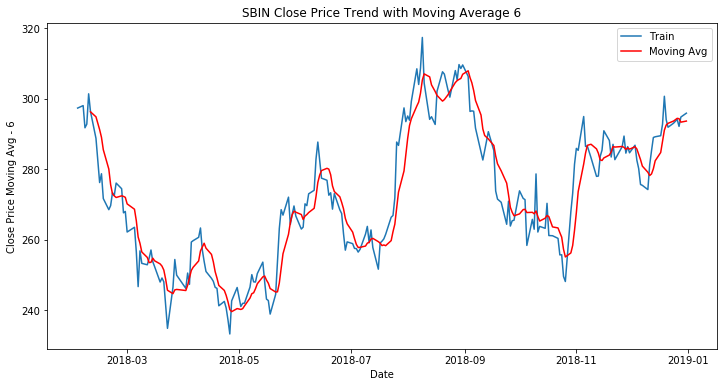

In [10]:
plt.figure(figsize=(12,6))
plt.plot(train_df.index, train_df, label='Train')
plt.plot(moving_avg_df.index, moving_avg_df, color='red', label='Moving Avg')
plt.xlabel('Date')
plt.ylabel('Close Price Moving Avg - 6')
plt.legend(loc='best')
plt.title('SBIN Close Price Trend with Moving Average 6')
plt.show()

There is some trend observed in the data. Let's run stationarity test now.

**Dickey-Fuller Test:** This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary. Refer this article for details https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/.

In [11]:
#Perform Dickey-Fuller test:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(train_df['Close Price'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -2.158171
p-value                          0.221776
#Lags Used                       0.000000
Number of Observations Used    222.000000
Critical Value (1%)             -3.460154
Critical Value (5%)             -2.874649
Critical Value (10%)            -2.573757
dtype: float64


p-value is greater than 0.05. So the timeseries is non-stationary.

In [12]:
# To remove trend in the time series
moving_avg_diff = train_df - moving_avg_df
moving_avg_diff.dropna(inplace=True)
moving_avg_diff.head()

,Close Price
Date,
2018-02-09,0.108333
2018-02-12,-6.108333
2018-02-14,-15.016667
2018-02-15,-10.341667
2018-02-16,-13.866667


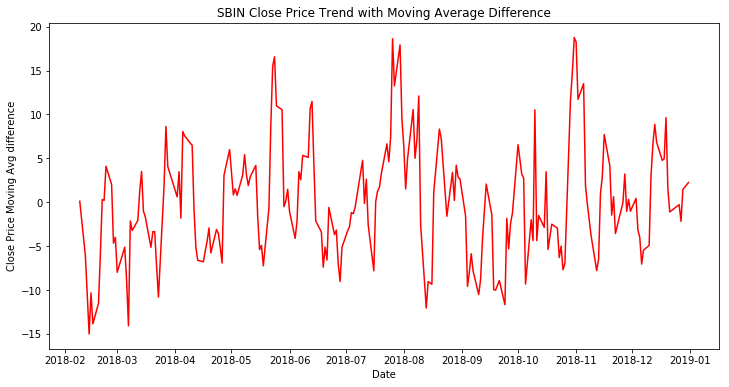

In [13]:
plt.figure(figsize=(12,6))
plt.plot(moving_avg_diff.index, moving_avg_diff, color='red')
plt.xlabel('Date')
plt.ylabel('Close Price Moving Avg difference')
plt.title('SBIN Close Price Trend with Moving Average Difference')
plt.show()

In [14]:
#Perform Dickey-Fuller test:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(moving_avg_diff['Close Price'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -6.741923e+00
p-value                        3.103209e-09
#Lags Used                     2.000000e+00
Number of Observations Used    2.150000e+02
Critical Value (1%)           -3.461136e+00
Critical Value (5%)           -2.875079e+00
Critical Value (10%)          -2.573986e+00
dtype: float64


p-value is lesser than 0.05. So the timeseries is stationary now.

A drawback in this particular approach is that the time-period has to be strictly defined. In this case we can take yearly averages but in complex situations like forecasting a stock price, its difficult to come up with a number. So we take a ‘weighted moving average’ where more recent values are given a higher weight. There can be many technique for assigning weights. A popular one is **exponentially weighted moving average** where weights are assigned to all the previous values with a decay factor. Find details here http://pandas.pydata.org/pandas-docs/stable/computation.html#exponentially-weighted-moment-functions.

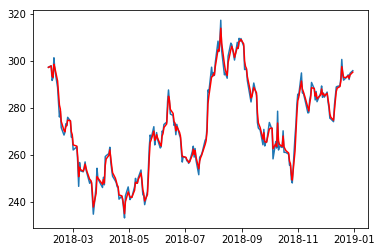

In [15]:
expwighted_avg = train_df.ewm(com=0.5).mean()
plt.plot(train_df)
plt.plot(expwighted_avg, color='red')

In [16]:
# To remove trend in the time series
expwighted_avg_diff = train_df - expwighted_avg
expwighted_avg_diff.dropna(inplace=True)
expwighted_avg_diff.head()

,Close Price
Date,
2018-02-02,0.000000
2018-02-05,0.175000
2018-02-06,-1.884615
2018-02-07,-0.271250
2018-02-08,2.753306


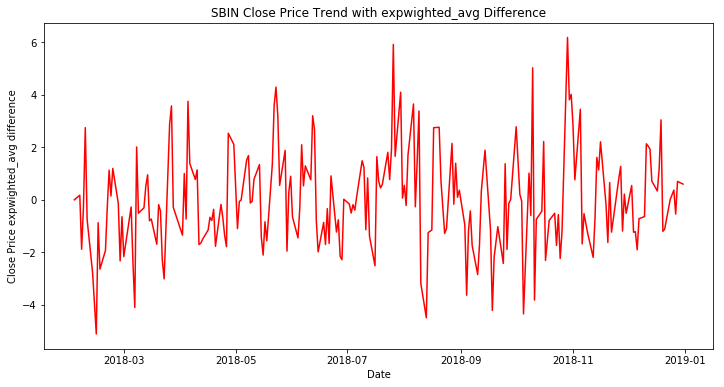

In [17]:
plt.figure(figsize=(12,6))
plt.plot(expwighted_avg_diff.index, expwighted_avg_diff, color='red')
plt.xlabel('Date')
plt.ylabel('Close Price expwighted_avg difference')
plt.title('SBIN Close Price Trend with expwighted_avg Difference')
plt.show()

In [18]:
#Perform Dickey-Fuller test:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(expwighted_avg_diff['Close Price'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -1.083802e+01
p-value                        1.642968e-19
#Lags Used                     0.000000e+00
Number of Observations Used    2.220000e+02
Critical Value (1%)           -3.460154e+00
Critical Value (5%)           -2.874649e+00
Critical Value (10%)          -2.573757e+00
dtype: float64


But the p-value for expwighted_avg_diff is greater than 0.05. So we go with the moving average difference.

**Since seasonality is not present in the timeseries, no need to remove it.**

# Eliminating Trend and Seasonality

Remove seasonality using Differencing method – taking the differece with a particular time lag

In [19]:
#moving_lag_diff = train_df - train_df.shift()
moving_lag_diff = expwighted_avg_diff.diff(12)
moving_lag_diff.dropna(inplace=True)
moving_lag_diff.head()

,Close Price
Date,
2018-02-21,1.129990
2018-02-22,-0.031670
2018-02-23,3.082392
2018-02-26,0.137175
2018-02-27,-5.081331


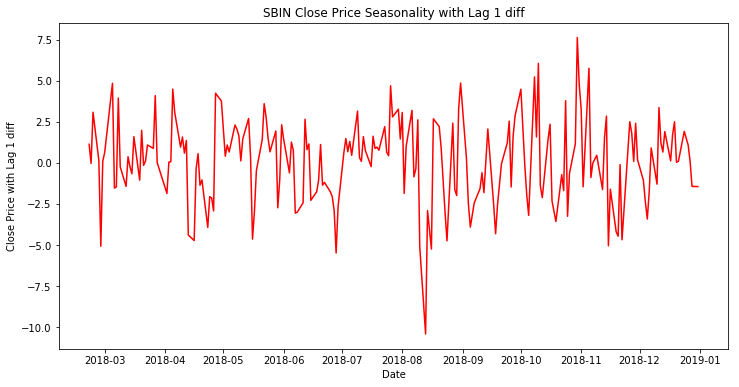

In [20]:
plt.figure(figsize=(12,6))
plt.plot(moving_lag_diff.index, moving_lag_diff, color='red')
plt.xlabel('Date')
plt.ylabel('Close Price with Lag 1 diff')
plt.title('SBIN Close Price Seasonality with Lag 1 diff')
plt.show()

In [21]:
#Perform Dickey-Fuller test:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(moving_lag_diff['Close Price'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)


Results of Dickey-Fuller Test:
Test Statistic                  -4.411126
p-value                          0.000284
#Lags Used                      12.000000
Number of Observations Used    198.000000
Critical Value (1%)             -3.463815
Critical Value (5%)             -2.876251
Critical Value (10%)            -2.574611
dtype: float64


# Decomposing (To remove both Trend and Seasonality)

In this approach, both trend and seasonality are modeled separately and the remaining part of the series is returned.

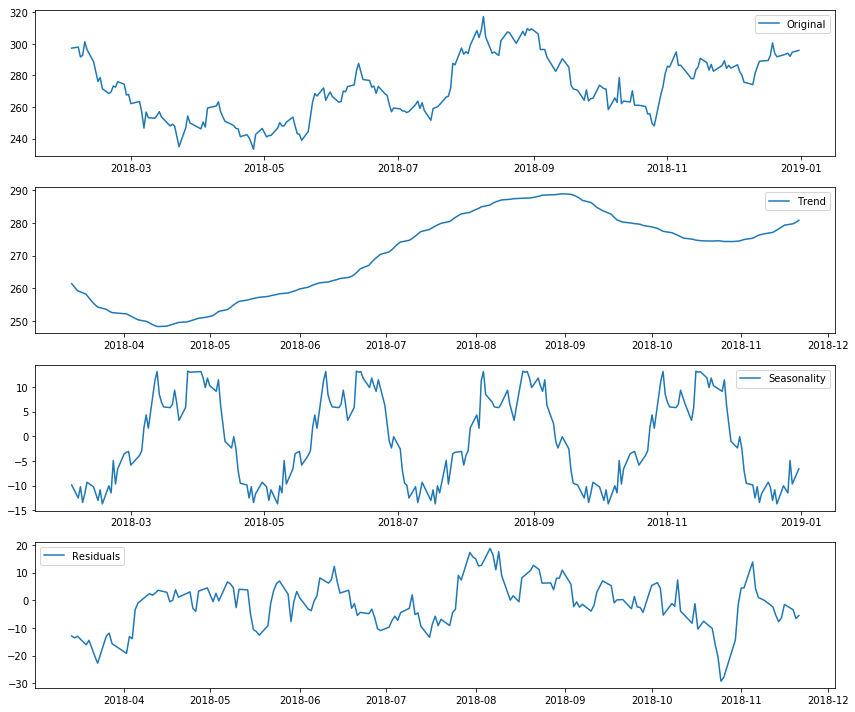

In [22]:
decomposition = seasonal_decompose(train_df, freq = 52)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(12,10))

plt.subplot(411)
plt.plot(train_df, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

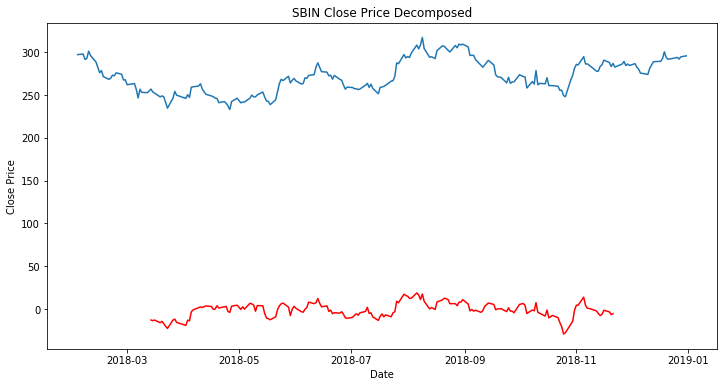

In [23]:
decomposed_df = residual.dropna()

plt.figure(figsize=(12,6))
plt.plot(train_df.index, train_df)
plt.plot(decomposed_df.index, decomposed_df, color='red')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('SBIN Close Price Decomposed')
plt.show()

# Forecasting a Time Series

## ARIMA

Here we use moving average log time series data which is already detrended(stationary form)

Having performed the trend and seasonality estimation techniques, there can be two situations:

1) A strictly stationary series with no dependence among the values. This is the easy case wherein we can model the residuals as white noise. But this is very rare.

2) A series with significant dependence among values. In this case we need to use some statistical models like ARIMA to forecast the data.

Let me give you a brief introduction to ARIMA. I won’t go into the technical details but you should understand these concepts in detail if you wish to apply them more effectively. ARIMA stands for Auto-Regressive Integrated Moving Averages. The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation. The predictors depend on the parameters (p,d,q) of the ARIMA model:

1) Number of AR (Auto-Regressive) terms (p): AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).

2) Number of MA (Moving Average) terms (q): MA terms are lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.

3) Number of Differences (d): These are the number of nonseasonal differences, i.e. in this case we took the first order difference. So either we can pass that variable and put d=0 or pass the original variable and put d=1. Both will generate same results.

An importance concern here is how to determine the value of ‘p’ and ‘q’. We use two plots to determine these numbers. Lets discuss them first.

1) Autocorrelation Function (ACF): It is a measure of the correlation between the the TS with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’t2’ with series at instant ‘t1-5’…’t2-5’ (t1-5 and t2 being end points).

2) Partial Autocorrelation Function (PACF): This measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. Eg at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.

In [24]:
lag_acf = acf(moving_lag_diff, nlags=20)
lag_pacf = pacf(moving_lag_diff, nlags=20, method='ols')

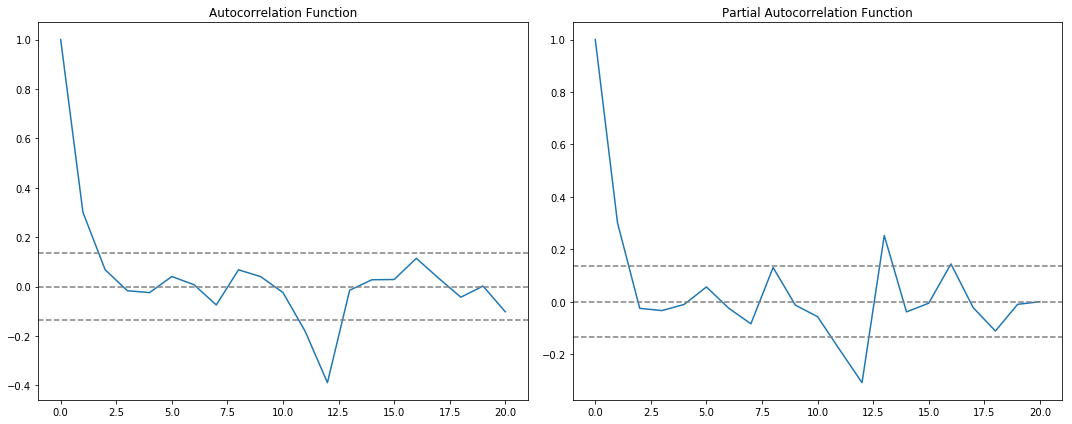

In [25]:
#Plot ACF: 
plt.figure(figsize=(15,6))
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(moving_lag_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(moving_lag_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(moving_lag_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(moving_lag_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In this plot, the two dotted lines on either sides of 0 are the confidence interevals. These can be used to determine the ‘p’ and ‘q’ values as:

* p – The lag value where the PACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case p=2.

* q – The lag value where the ACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case q=8.

The p,d,q values can be specified using the order argument of ARIMA which take a tuple (p,d,q). Let us model the 3 cases:

### AR Model

C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jsaikumar\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\jsaikumar\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different resu

Text(0.5, 1.0, 'RMSE: 2.4480')

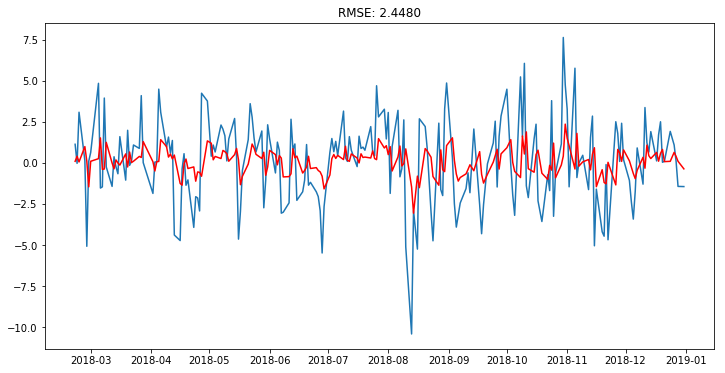

In [26]:
model = ARIMA(moving_lag_diff, order=(1, 0, 0))  
results_AR = model.fit(disp=-1)  
plt.figure(figsize=(12,6))
plt.plot(moving_lag_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RMSE: %.4f' % ( np.sqrt( mean_squared_error( moving_lag_diff['Close Price'], results_AR.fittedvalues ) ) ) )

### MA Model

C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Text(0.5, 1.0, 'RMSE: 2.4543')

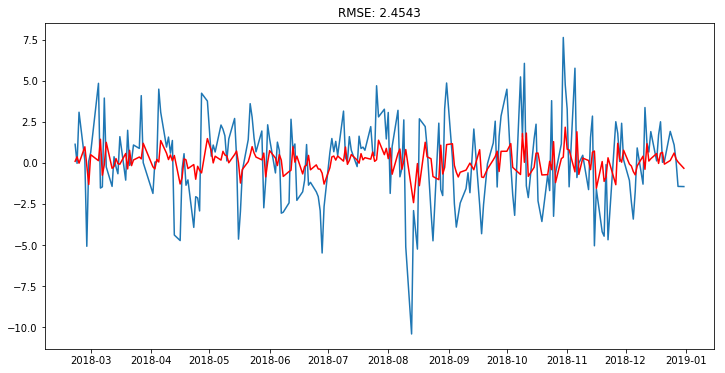

In [27]:
model = ARIMA(moving_lag_diff, order=(0, 0, 1))  
results_MA = model.fit(disp=-1)  
plt.figure(figsize=(12,6))
plt.plot(moving_lag_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RMSE: %.4f' % ( np.sqrt( mean_squared_error( moving_lag_diff['Close Price'], results_MA.fittedvalues ) ) ) )

### Combined Model

C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Text(0.5, 1.0, 'RMSE: 2.4474')

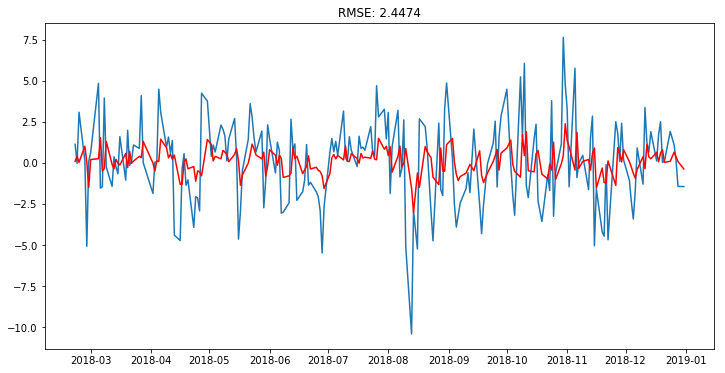

In [28]:
model = ARIMA(moving_lag_diff, order=(1, 0, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.figure(figsize=(12,6))
plt.plot(moving_lag_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RMSE: %.4f' % ( np.sqrt( mean_squared_error( moving_lag_diff['Close Price'], results_ARIMA.fittedvalues ) ) ) )

In [29]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

Date
2018-02-21    0.092332
2018-02-22    0.404119
2018-02-23    0.033516
2018-02-26    1.012785
2018-02-27    0.044619
dtype: float64

In [30]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

Date
2018-02-21    0.092332
2018-02-22    0.496451
2018-02-23    0.529967
2018-02-26    1.542751
2018-02-27    1.587371
dtype: float64

In [31]:
#predictions_ARIMA_log = pd.Series(train_df.iloc[0], index=train_df.index)
#predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
#predictions_ARIMA_log.head()

Text(0.5, 1.0, 'RMSE: nan')

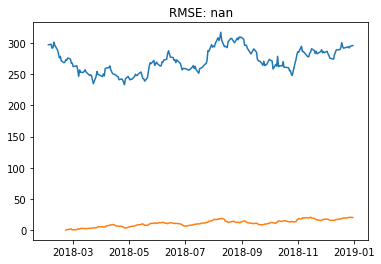

In [32]:
plt.plot(train_df)
plt.plot(predictions_ARIMA_diff_cumsum)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA_diff_cumsum - train_df['Close Price'])**2)/len(train_df)))

# SARIMAX

In [33]:
lag_acf = acf(train_df, nlags=40)
lag_pacf = pacf(train_df, nlags=40, method='ols')

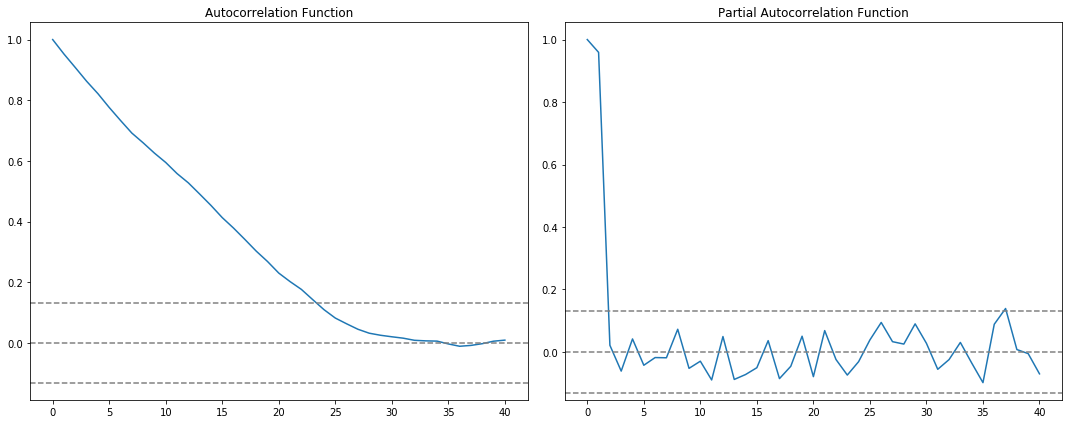

In [34]:
#Plot ACF: 
plt.figure(figsize=(15,6))
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_df)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_df)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_df)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_df)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

### Hyperparameter Tuning

In [42]:
import itertools

# Define the p, d and q parameters to take any value between 0 and 2
p = [0, 1]
d = [1]
q = [0, 1, 23]
s = [12, 18]

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], x[3]) for x in list(itertools.product(p, d, q, s))]
AIC = float('inf')
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(  train_df['Close Price'],
                            order=param,
                            seasonal_order=param_seasonal,
                            enforce_stationarity=False,
                            enforce_invertibility=False)

            #results = mod.fit(maxiter=100, method='powell')
            results = mod.fit()

            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            
            if results.aic < AIC:
                AIC = results.aic
                best_params = param
                best_params_sesonal = param_seasonal
                
        except Exception as e:
            print(e)
            continue

C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


SARIMAX(0, 1, 0)x(0, 1, 0, 12) - AIC:1430.8844244429483
SARIMAX(0, 1, 0)x(0, 1, 0, 18) - AIC:1417.6128779871406
SARIMAX(0, 1, 0)x(0, 1, 1, 12) - AIC:1253.0679189017067


C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


SARIMAX(0, 1, 0)x(0, 1, 1, 18) - AIC:1195.16513622073
maxlag should be < nobs
maxlag should be < nobs
SARIMAX(0, 1, 0)x(1, 1, 0, 12) - AIC:1313.8855926840524
SARIMAX(0, 1, 0)x(1, 1, 0, 18) - AIC:1257.1029604830178


C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency infor

SARIMAX(0, 1, 0)x(1, 1, 1, 12) - AIC:1254.986461236967


C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


SARIMAX(0, 1, 0)x(1, 1, 1, 18) - AIC:1197.0745900994973
maxlag should be < nobs
maxlag should be < nobs
SARIMAX(0, 1, 1)x(0, 1, 0, 12) - AIC:1425.2016635356129
SARIMAX(0, 1, 1)x(0, 1, 0, 18) - AIC:1412.914475218547


C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency infor

SARIMAX(0, 1, 1)x(0, 1, 1, 12) - AIC:1249.3492938693814


C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


SARIMAX(0, 1, 1)x(0, 1, 1, 18) - AIC:1188.680424438506
maxlag should be < nobs
maxlag should be < nobs
SARIMAX(0, 1, 1)x(1, 1, 0, 12) - AIC:1315.835270985161


C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency infor

SARIMAX(0, 1, 1)x(1, 1, 0, 18) - AIC:1258.9253879617218


C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


SARIMAX(0, 1, 1)x(1, 1, 1, 12) - AIC:1251.2457958285872


C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


SARIMAX(0, 1, 1)x(1, 1, 1, 18) - AIC:1190.5702651038596
maxlag should be < nobs
maxlag should be < nobs


C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


SARIMAX(0, 1, 23)x(0, 1, 0, 12) - AIC:1220.5362906420114


C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


SARIMAX(0, 1, 23)x(0, 1, 0, 18) - AIC:1201.934503924717


C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


SARIMAX(0, 1, 23)x(0, 1, 1, 12) - AIC:1143.4966503601127


C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


SARIMAX(0, 1, 23)x(0, 1, 1, 18) - AIC:1076.0900914490526
maxlag should be < nobs
maxlag should be < nobs


C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


SARIMAX(0, 1, 23)x(1, 1, 0, 12) - AIC:1222.5361969008472


C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


SARIMAX(0, 1, 23)x(1, 1, 0, 18) - AIC:1204.6161845602835


C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX(0, 1, 23)x(1, 1, 1, 12) - AIC:1143.146085756351


C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


SARIMAX(0, 1, 23)x(1, 1, 1, 18) - AIC:1079.8395944944555
maxlag should be < nobs
maxlag should be < nobs
SARIMAX(1, 1, 0)x(0, 1, 0, 12) - AIC:1432.7770353065039
SARIMAX(1, 1, 0)x(0, 1, 0, 18) - AIC:1418.8124564819968


C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency infor

SARIMAX(1, 1, 0)x(0, 1, 1, 12) - AIC:1255.066846241185


C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


SARIMAX(1, 1, 0)x(0, 1, 1, 18) - AIC:1196.7561336706663
maxlag should be < nobs
maxlag should be < nobs
SARIMAX(1, 1, 0)x(1, 1, 0, 12) - AIC:1310.1245993782484


C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency infor

SARIMAX(1, 1, 0)x(1, 1, 0, 18) - AIC:1252.6972303138741


C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


SARIMAX(1, 1, 0)x(1, 1, 1, 12) - AIC:1256.986079991127


C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


SARIMAX(1, 1, 0)x(1, 1, 1, 18) - AIC:1198.7557345109064
maxlag should be < nobs
maxlag should be < nobs


C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


SARIMAX(1, 1, 1)x(0, 1, 0, 12) - AIC:1422.5299833514973
SARIMAX(1, 1, 1)x(0, 1, 0, 18) - AIC:1414.2898131725135


C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


SARIMAX(1, 1, 1)x(0, 1, 1, 12) - AIC:1248.6699368769648


C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


SARIMAX(1, 1, 1)x(0, 1, 1, 18) - AIC:1189.4417873110735
maxlag should be < nobs
maxlag should be < nobs


C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


SARIMAX(1, 1, 1)x(1, 1, 0, 12) - AIC:1310.018330967741


C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


SARIMAX(1, 1, 1)x(1, 1, 0, 18) - AIC:1252.728615498003


C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


SARIMAX(1, 1, 1)x(1, 1, 1, 12) - AIC:1250.6553059280764


C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


SARIMAX(1, 1, 1)x(1, 1, 1, 18) - AIC:1191.2723219614604
maxlag should be < nobs
maxlag should be < nobs


C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "C

SARIMAX(1, 1, 23)x(0, 1, 0, 12) - AIC:1222.2011504156003


C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX(1, 1, 23)x(0, 1, 0, 18) - AIC:1202.1056901067504


C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX(1, 1, 23)x(0, 1, 1, 12) - AIC:1145.564498421139


C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX(1, 1, 23)x(0, 1, 1, 18) - AIC:1077.7271578800332
maxlag should be < nobs
maxlag should be < nobs


C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "C

SARIMAX(1, 1, 23)x(1, 1, 0, 12) - AIC:1224.2201920397295


C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX(1, 1, 23)x(1, 1, 0, 18) - AIC:1206.5468396551296


C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX(1, 1, 23)x(1, 1, 1, 12) - AIC:1140.411507217304


C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX(1, 1, 23)x(1, 1, 1, 18) - AIC:1079.7783388572684
maxlag should be < nobs
maxlag should be < nobs


C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [43]:
print('Order param:', best_params)
print('Seasonal param:', best_params_sesonal)

Order param: (0, 1, 23)
Seasonal param: (0, 1, 1, 18)


In [45]:
# Training Seasonal ARIMA model to forcast the data 
model = SARIMAX(train_df['Close Price'], trend='n', order=best_params, seasonal_order=best_params_sesonal, enforce_invertibility=False)
results = model.fit()
print(results.summary())

C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                                  Statespace Model Results                                 
Dep. Variable:                         Close Price   No. Observations:                  223
Model:             SARIMAX(0, 1, 23)x(0, 1, 1, 18)   Log Likelihood                -655.343
Date:                             Sat, 02 Feb 2019   AIC                           1360.686
Time:                                     20:22:49   BIC                           1443.639
Sample:                                          0   HQIC                          1394.241
                                             - 223                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0394    214.052     -0.000      1.000    -419.574     419.496
ma.L2          0.0158    24

C:\Users\jsaikumar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\jsaikumar\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


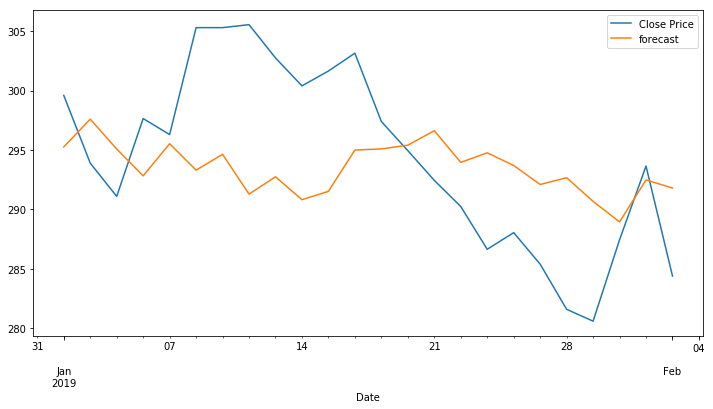

In [46]:
# Predict the test data
#test_df['forecast'] = list(results.predict(start=len(train_df), end=( len(train_df) + len(test_df) - 1 ), dynamic=True))
test_df['forecast'] = list(results.predict(start=pd.to_datetime('2019-01-01'), end=pd.to_datetime('2019-02-01'), dynamic=True))
test_df[['Close Price', 'forecast']].plot(figsize=(12, 6))
plt.show()

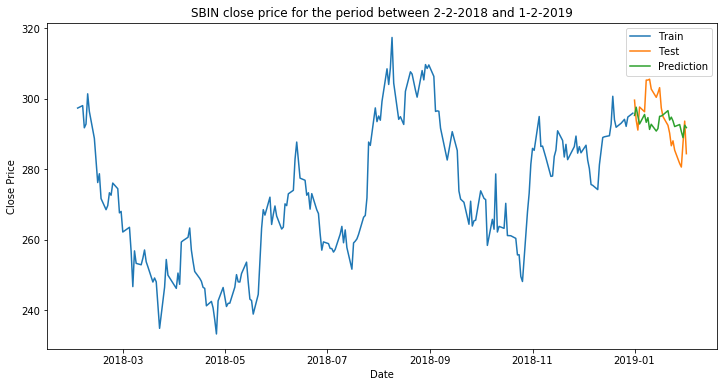

In [47]:
# Prediction Comparison plot 
plt.figure(figsize=(12,6))
plt.plot(train_df.index, train_df['Close Price'], label='Train')
plt.plot(test_df.index, test_df['Close Price'], label='Test')
plt.plot(test_df.index, test_df['forecast'], label='Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend(loc='best')
plt.title('SBIN close price for the period between 2-2-2018 and 1-2-2019')
plt.show()

In [48]:
# Evaluation - Squared Error 
rms = np.sqrt(mean_squared_error(test_df['Close Price'], test_df['forecast']))
print(rms)

7.516212151681017


# LSTM (Long Short-Term Memory Network)

In [198]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(master_df)

In [199]:
# split into train and test sets
train_size = 223
test_size = 24
# Actual train size is 223 but given with +1, since we use shift(-1) for the Y-Value
train = scaled_data[0:train_size,:]
test = scaled_data[train_size:,:]
print(len(train), len(test))

223 24


In [200]:
look_back = 120

x_train, y_train = [], []

for i in range( look_back, len(train) ):
    x_train.append( scaled_data[ i - look_back : i, 0 ] )
    y_train.append( scaled_data[ i, 0 ] )
    
x_train, y_train = np.array(x_train), np.array(y_train)

In [201]:
# reshape input to be 3-D as [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [202]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

Epoch 1/1
 - 17s - loss: 0.0396


In [203]:
#predicting 24 values, using past 120 from the train data
inputs = master_df[len(master_df) - len(test) - look_back:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

In [204]:
X_test = []
for i in range( look_back, inputs.shape[0] ):
    X_test.append( inputs[ i - look_back:i, 0 ] )
    
X_test = np.array(X_test)

In [205]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [206]:
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

In [207]:
test_df['LSTM_forecast'] = closing_price

C:\Users\jsaikumar\Anaconda3\envs\TensorFlow\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


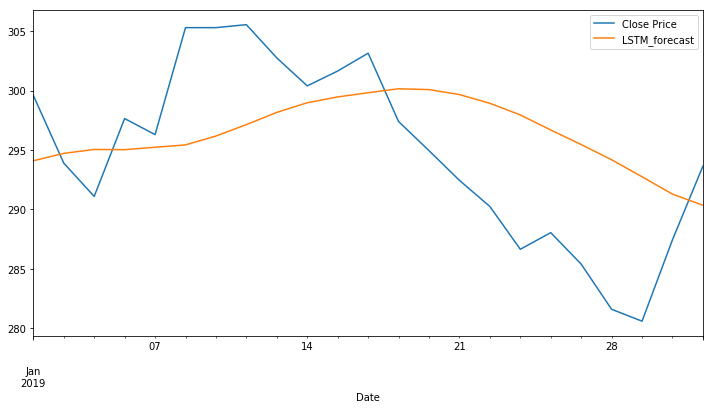

In [208]:
test_df[['Close Price', 'LSTM_forecast']].iloc[:-1].plot(figsize=(12, 6))

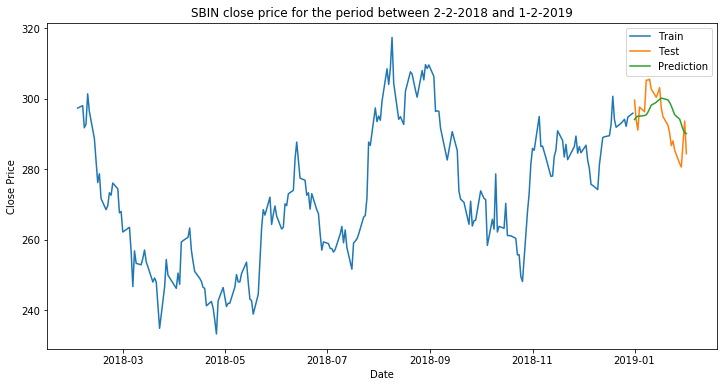

In [209]:
# Prediction Comparison plot 
plt.figure(figsize=(12,6))
plt.plot(train_df.index, train_df['Close Price'], label='Train')
plt.plot(test_df.index, test_df['Close Price'], label='Test')
plt.plot(test_df.index, test_df['LSTM_forecast'], label='Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend(loc='best')
plt.title('SBIN close price for the period between 2-2-2018 and 1-2-2019')
plt.show()

In [210]:
# Evaluation - Squared Error 
rms = np.sqrt(mean_squared_error(test_df['Close Price'], test_df['LSTM_forecast']))
print(rms)

6.9948735333185645
